# Lecture 4: Entanglement in Action
from IBM Quantum Computing: Basics of Quantum Information ([Ref Here!](https://learning.quantum.ibm.com/course/basics-of-quantum-information/quantum-circuits))

이번 강의에서는 Quantum Information의 가장 기본적인 protocol과 implementation 3가지를 다루었다.  

- Quantum teleportation
- ⇔ Superdense coding
- CHSH game

이들은 모두 **Entanglement**를 필요로하며, *e-bit*; entangled-qubit 없이는 불가능한 내용을 다루고 있다.  

양자역학에서 entanglement; 얽힘은 직관적으로 이해하기 힘들고, 이를 추상적인 말로서 설명하는 것보다는 entanglement가 얼마나 신기한 현상들을 야기시킬 수 있는지를 3가지 활용으로부터 보여주고자한다.

## Quantum teleportation

> **Objective*: Alice가 자신이 가지고 있는 qubit $Q$의 quantum state를 Bob에게 전송하는 것. 단, 오직 **classical communication**만을 사용해야한다.

##### Quantum teleportation setting:
**Setting**
- Alice는 Bob에게 전송하려는 qubit $Q$를 가진다.
- Alice와 Bob은 $\ket{\phi^+}$ state로 표현되는 e-bit $(A, B)$를 공유한다. (=서로 얽힌 qubit $A, B$를 각각 가진다.)


**Contraint**
- Qubit를 물리적으로 직접 전송하는 것은 불가능하다.
- Alice는 quantum state인 qubit의 state를 알 수 없다. 
- Non-cloning theorem에 의해 Alice가 Bob에게 $Q$의 정보를 전송한 후에는 Alice는 $Q$에 대한 정보를 알 수 없어야한다.
- $Q$가 다른 system과 얽혀있으면, 전송된 qubit의 정보 또한 $Q$가 얽혀있던 system과 서로 얽힘상태여야한다.

##### Quantum teleportation protocol:
--- 

1. Alice performs a **controlled-NOT** operation, where $Q$ is the control and $A$ is the target.
2. Alice performs a **Hadamard** operation on $Q$.
3. Alice measures $A$ and $Q$, obtaining binary outcomes $a$ and $b$, respectively.
4. Alice sends $a$ and $b$ to Bob.
5. Bob performs these two steps:
	1. If $a = 1$, then Bob applies an $X$ operation to the qubit $B$.
	2. If $b = 1$, then Bob applies a $Z$ operation to the qubit $B$.

---



*Here is a quantum circuit implementation of the teleportation protocol.*

In [8]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

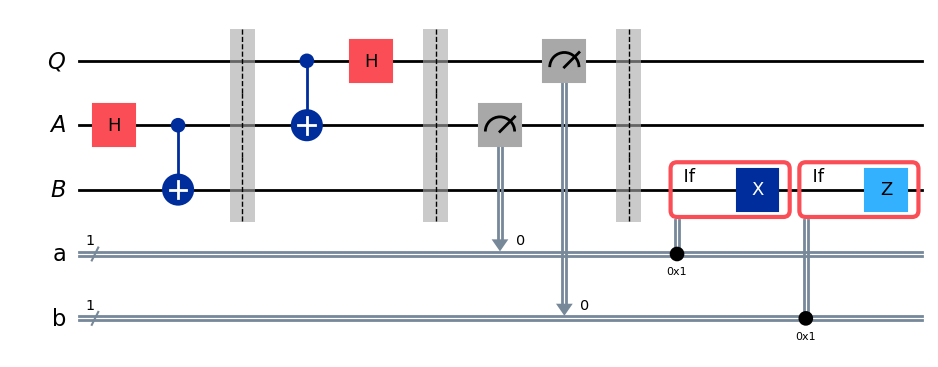

In [3]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# A, B를 서로 얽힘 상태 \phi^+가 되도록 준비한다. 
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operation -> (I \otimes H) CNOT
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob;s operation
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw('mpl'))

In [4]:
# 어떤 random gate를 전송된 qubit에 적용한 뒤 측정한다.
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[-0.1953261 +0.j        , -0.53704077-0.82063081j],
       [ 0.95194599+0.23589519j, -0.06450659-0.18436698j]])

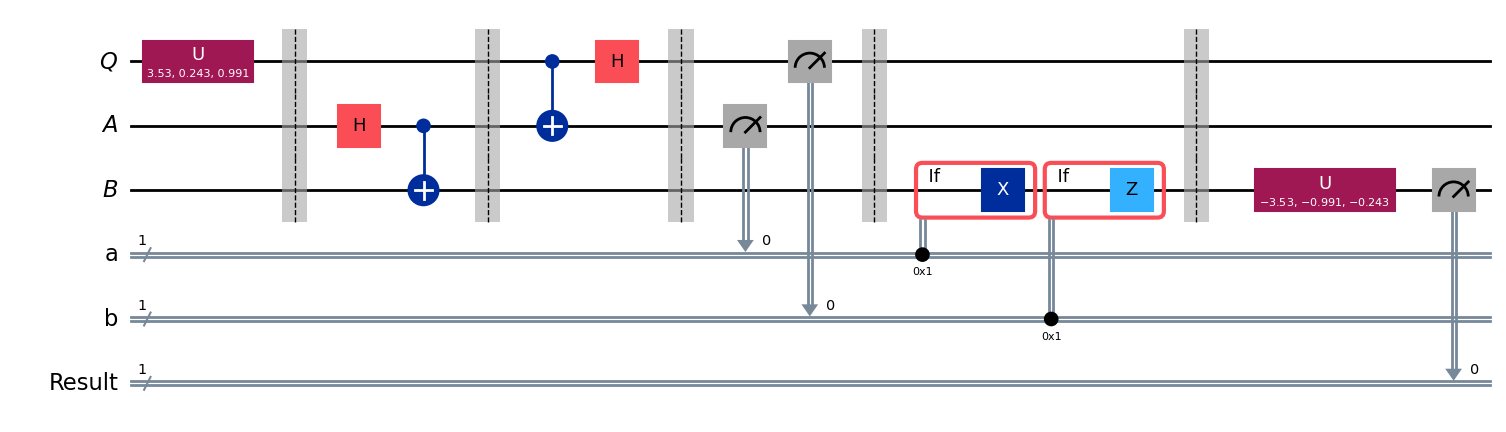

In [6]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.
test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.
test.append(random_gate.inverse(), ebit1)

result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw('mpl'))

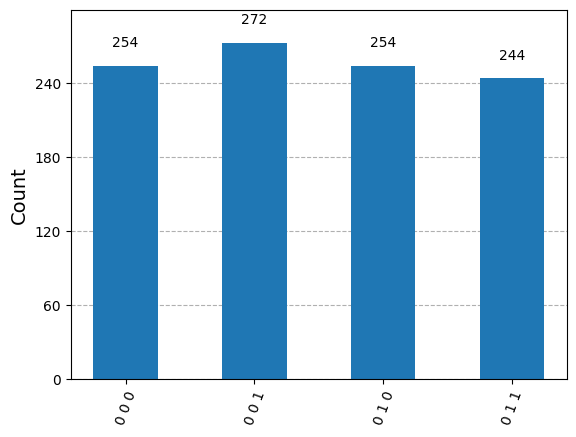

In [7]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

## Superdense coding
> **Objective*: Alice가 자신이 가지고 있는 2개의 classical bit $a, b$의 information을 Bob에게 전송하는 것. 단, 오직 **quantum communication**만을 사용해야한다.

##### Superdense coding setting:

- Alice는 Bob에게 전송하려는 classical bit $a,b$를 가진다.
- Alice와 Bob은 $\ket{\phi^+}$ state로 표현되는 e-bit $(A, B)$를 공유한다. (=서로 얽힌 qubit $A, B$를 각각 가진다.)


##### Superdense coding protocol:
---

1. Alice performs these two steps:
	1. If $b = 1$, then Alice applies an $Z$ operation to the qubit $A$.
	2. If $a = 1$, then Alice applies a $X$ operation to the qubit $A$.
2. Alice sends $A$ to Bob.
3. Bob performs a **controlled-NOT** operation, where $A$ is the control and $B$ is the target.
4. Bob performs a **Hadamard** operation on $A$.
5. Bob measures $A$ and $B$, obtaining binary outcomes $b$ and $a$, respectively.

---

*Here is a simple implementation of superdense coding where we specify the circuit itself depending on the bits to be transmitted.*

In [9]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [10]:
# Prepare two-classical bits that Alice wants to send bob.
c = "1"
d = "0"

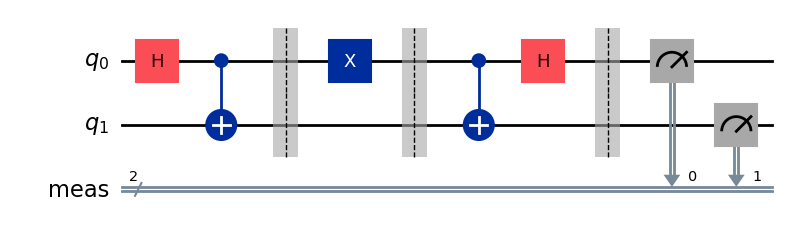

In [12]:
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw('mpl'))

Measured 10 with frequency 1.0


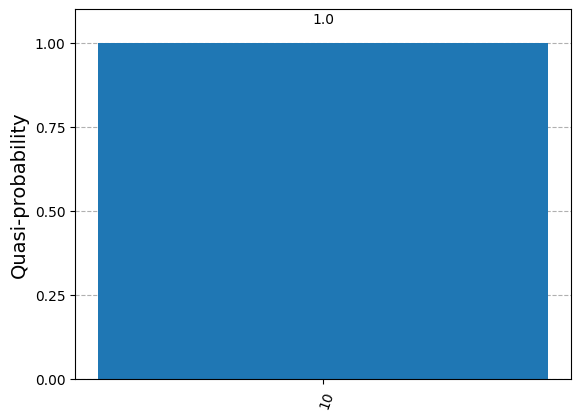

In [13]:
result = Sampler().run(protocol).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

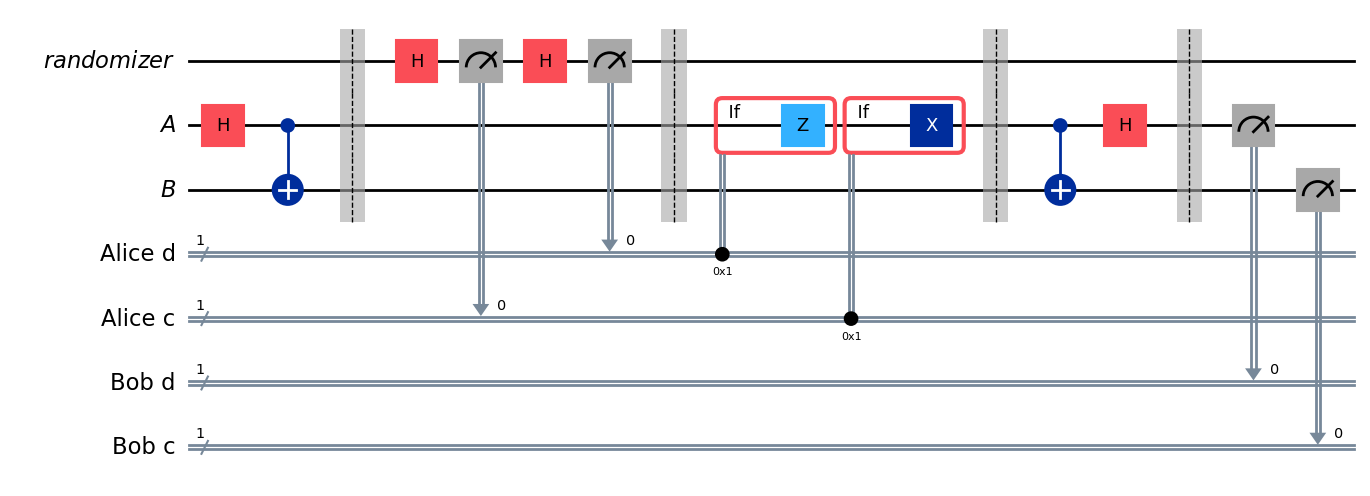

In [15]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw('mpl'))

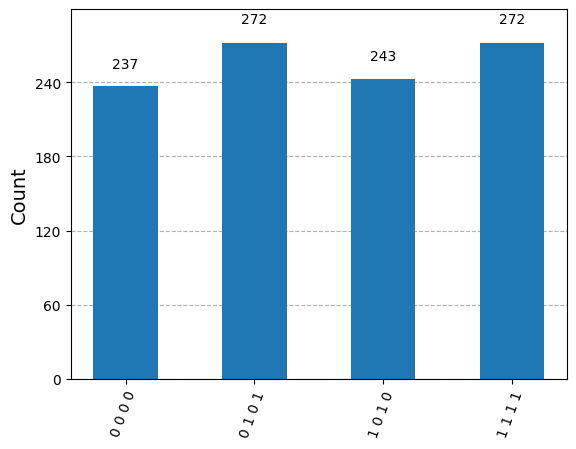

In [16]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

## CHSH game
##### CHSH game setting:

1. Alice performs a **controlled-NOT** operation, where $Q$ is the control and $A$ is the target.
2. Alice performs a **Hadamard** operation on $Q$.
3. Alice measures $A$ and $Q$, obtaining binary outcomes $a$ and $b$, respectively.
4. Alice sends $a$ and $b$ to Bob.
5. Bob performs these two steps:
	1. If $a = 1$, then Bob applies an $X$ operation to the qubit $B$.
	2. If $b = 1$, then Bob applies a $Z$ operation to the qubit $B$.

##### CHSH game strategy:
---
1. Define quantum state and Unitary operation $U_\theta$:
$$ U_\theta = \ket 0 \bra{\psi_\theta} + \ket 1 \bra{\psi_{\theta + \pi / 2}}. $$ 
*where* quantum state vector $\ket \psi_\theta$ is 
$$ \ket{\psi_\theta} = \cos(\theta) \ket 0 + \sin (\theta) \ket 1 . $$
2. Alice and Bob share an e-bit $(A, B)$.
3. Alice and Bob performs following steps:
    1. Alice performs these two steps:
        1. If Alice's question $x = 0$, then Alice applies an $U_0$ operation to the qubit $A$.
        2. If Alice's question $x = 1$, then Alice applies an $U_{\pi/4}$ operation to the qubit $A$.
    2. Bob performs these two steps:
        1. If Bob's question $y = 0$, then Alice applies an $U_{\pi/8}$ operation to the qubit $B$.
        2. If Bob's question $y = 1$, then Alice applies an $U_{-\pi/8}$ operation to the qubit $B$.
4. Alice measures $A$ and response result as answer $a$ and Bob measures $B$ and response result as answer $b$.
---

We can implement the CHSH game together with the quantum strategy defined above in Qiskit as follows.

In [17]:
# Required imports

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from numpy import pi
from numpy.random import randint

In [18]:
def chsh_game(strategy):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    x, y = randint(0, 2), randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

In [19]:
def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

(x,y) = (0,0)


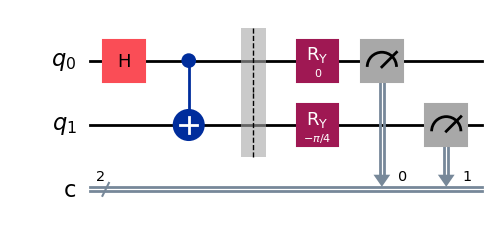

(x,y) = (0,1)


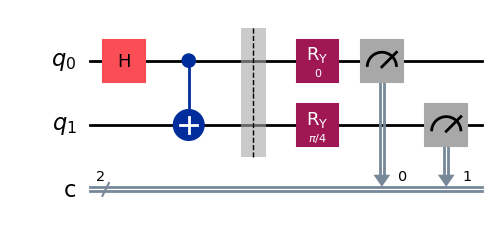

(x,y) = (1,0)


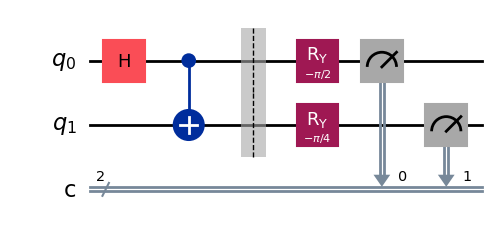

(x,y) = (1,1)


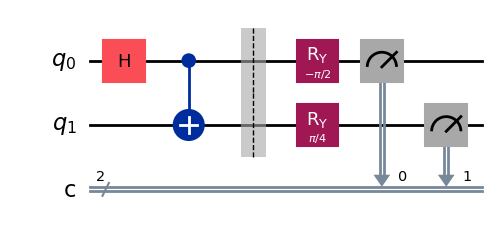

In [20]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw('mpl'))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw('mpl'))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw('mpl'))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw('mpl'))

In [21]:
sampler = Sampler()


def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

In [22]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.842


In [23]:
def classical_strategy(x, y):
    """An optimal classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

In [24]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.752
